In [4]:
import torch
import torch.nn as nn
from torch.nn.functional import batch_norm
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [36]:
from pathlib import Path

dt_p = Path('data/mnist')

batch_size = 128
n_channels, w, h = 1, 28, 28

classes = [str(i) for i in range(10)]
n_labels = len(classes)

transform = transforms.Compose(
    [transforms.ToTensor()])

    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


trainset = datasets.MNIST(root=f'{dt_p.absolute()}/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.MNIST(root=f'{dt_p.absolute()}/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



In [40]:


class Net(nn.Module):
    def __init__(self, input_size=28):  # Add input size for flexibility
        super().__init__()
        self.conv1a = nn.Conv2d(1, 32, 3, padding=0)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=0)
        self.conv2a = nn.Conv2d(32, 64, 3, padding=0)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the number of features dynamically
        self._to_linear = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(self._to_linear, 200)
        self.fc2 = nn.Linear(200, 10)

        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(200)  # Now correctly applied

    def _get_conv_output(self, size):
        """Helper function to compute the output size after convolutions"""
        x = torch.zeros(1, 1, size, size)  # Create a dummy tensor
        x = self.pool(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool(F.relu(self.conv2b(F.relu(self.conv2a(x)))))
        return x.numel()

    def forward(self, x):
        x = self.activation(self.conv1a(x))
        x = self.activation(self.conv1b(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.activation(self.conv2a(x))
        x = self.activation(self.conv2b(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = self.flatten(x)  # Flatten before FC layers
        x = self.activation(self.fc1(x))
        x = self.batchnorm(x)
        x = self.fc2(x)
        # CrossEntropyLoss already applied softmax
        return x  # Remove softmax if using CrossEntropyLoss

    
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Playing on {device}")

Playing on mps


In [41]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
adam = torch.optim.AdamW(model.parameters(), lr=0.001)

  5%|▌         | 1/20 [00:03<01:04,  3.39s/it]

Epoch 0: 0.03417366370558739


 55%|█████▌    | 11/20 [00:35<00:29,  3.30s/it]

Epoch 10: 0.009503318928182125


100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


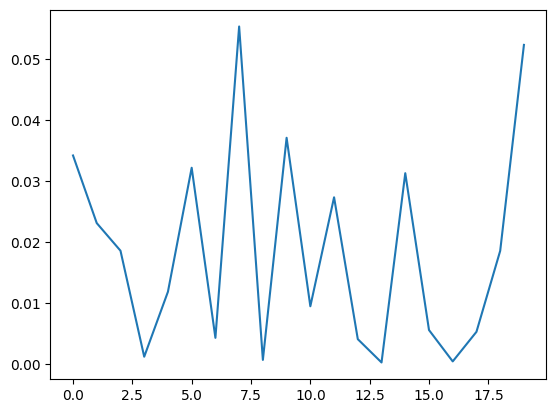

In [42]:
import time
losses = []

for e in tqdm(range(20)):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        labels_hat_dist = model(images)
        adam.zero_grad()
        loss = criterion(labels_hat_dist, labels)
        loss.backward()
        adam.step()
    losses.append(loss.item())
    if e % 10 == 0:
        print(f"Epoch {e}: {loss.item()}")

plt.plot(losses)
plt.show()

PATH = f'models/{time.strftime("%m%d-%H%M%S")}.pth'
torch.save(model.state_dict(), PATH)


## Direction Sensitivity Estimation
This section aims to experiment with the first of the two tasks [(Papernot et al., 2016)](https://arxiv.org/abs/1511.04508): Direction Sensitivity Estimation. Given a sample $X$ we want to test a trained model $F$ on perturbated version of the sample (i.e. $\delta X$) to find the dimensions of $X$ that will produce expected adversarial behavior (misclassification) with the *smallest* perturbation. We formalize the problem as a linear program:
$$\arg\min_{\delta X}||\delta X|| \text{ s.t. } F(X+\delta X) = Y^*$$
where $Y^*$ is the adverserial class indicator vector. Following [(Goodfellow et al., 2014)](https://arxiv.org/pdf/1412.6572) we calculate the sign of the gradient (i.e. `step = images.grad.sign()`) and after defining a perturbation of $\delta = 0.2$ and calculate the loss for both vanilla and perturbated sample to study the loss.

In [43]:

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)

# Inside train loop
images.requires_grad = True
labels_hat_dist = model(images)
loss = criterion(labels_hat_dist, labels)
loss.backward()

print("Original loss", loss.item())


step = images.grad.sign()
perturbed_image = images + 0.2*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)
print("Adv loss", loss.item())

Original loss 0.005828205030411482
Adv loss 1.216497778892517


GroundTruth:  6     3     1     4     9     2     4     2    
Predicted:  6     3     1     4     9     2     4     2    
Averserial:  5     5     2     2     5     3     3     6    
Attack:  succ succ succ succ succ succ succ succ


Delta loss: 6.745887458324432
	Original loss: 0.1576874852180481
	Adversarial loss: 6.9035749435424805


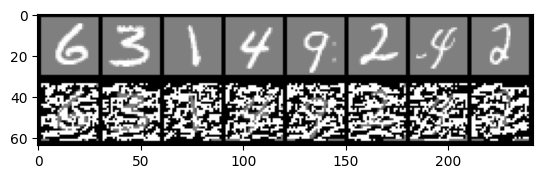

In [44]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images / 2 + 0.5

limit = 120

losses = []

grid = utils.make_grid(images[:(len(labels)-limit)])
# print images

gt = [f'{classes[labels[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('GroundTruth: ', ' '.join(gt))

net = model
#net.load_state_dict(torch.load(PATH, weights_only=True))

images, labels = images.to(device), labels.to(device)

images.requires_grad = True

outputs = net(images)
loss = criterion(outputs, labels)
loss.backward()

losses.append(loss.item())

_, predicted = torch.max(outputs, 1)

org = [f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]

print('Predicted: ', ' '.join(org))

step = images.grad.sign()

perturbed_image = images + 0.5*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

grid_n = utils.make_grid(perturbed_image[:(len(labels)-limit)])

grod = np.concatenate((np.transpose(grid, (1, 2, 0)),np.transpose(grid_n.cpu(), (1, 2, 0))))
# print images
plt.imshow(grod)


labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)

losses.append(loss.item())

_, predicted = torch.max(labels_hat_dist, 1)

adv = [f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels)-(limit))]


print('Averserial: ', ' '.join(adv))





res = []
for o, p, a in zip(org, gt, adv):
    if o != p:
        res.append('errr')
    elif o == p and o != a:
        res.append('succ')
    else:
        res.append('fail')

print(f'Attack: ', ' '.join(res))
print('\n')
print(f'Delta loss: {np.abs(losses[0]-losses[1])}\n\tOriginal loss: {losses[0]}\n\tAdversarial loss: {losses[1]}')

In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []
with torch.no_grad():
    for _ in tqdm(range(10)):
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)

print(f'Accuracy of the network on the 10000 test images: {np.mean(accuracies):.3f} %')

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

Accuracy of the network on the 10000 test images: 99.360 %
